In [ ]:
# MUSA 650 Homework 4: EuroSAT Land Use and Land Cover Classification
# Student Name: Yutong Jiang
# 1. Data Loading, Processing, and Exploration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import random
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import itertools
from google.colab import drive

drive.mount('/content/drive')

!wget -q https://zenodo.org/record/7711810/files/EuroSAT_RGB.zip
!unzip -q EuroSAT_RGB.zip

!ls -la
!ls -la EuroSAT_RGB/

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from tqdm import tqdm
import cv2
import zipfile
import urllib.request
import gdown
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace EuroSAT_RGB/Forest/Forest_864.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
total 277360
drwxr-xr-x  1 root root     4096 Apr 28 01:17 .
drwxr-xr-x  1 root root     4096 Apr 27 17:31 ..
drwxr-xr-x  4 root root     4096 Apr 24 18:19 .config
drwx------  7 root root     4096 Apr 27 17:36 drive
drwxr-xr-x 12 root root     4096 Mar  9  2023 EuroSAT_RGB
-rw-r--r--  1 root root 94658721 Apr 27 17:36 EuroSAT_RGB.zip
-rw-r--r--  1 root root 94658721 Apr 28 01:01 EuroSAT_RGB.zip.1
-rw-r--r--  1 root root 94658721 Apr 28 01:17 EuroSAT_RGB.zip.2
drwxr-xr-x  1 root root     4096 Apr 24 18:20 sample_data
total 1148
drwxr-xr-x 12 root root   4096 Mar  9  2023 .
drwxr-xr-x  1 root root   4096 Apr 28 01:17 ..
drwxr-xr-x  2 root root 135168 Apr 28 01:03 AnnualCrop
drwxr-xr-x  2 root root 118784 Apr 28 01:03 Forest
drwxr-xr-x  2 root root 167936 Apr 28 01:03 HerbaceousVe

In [ ]:
## 2. Traditional Machine Learning (Forest, Residential, Industrial only)

# Filter data for only Forest, Residential and Industrial classes
forest_idx = 1  # Forest
residential_idx = 7  # Residential
industrial_idx = 4  # Industrial

# Filter training and testing data
mask_train = np.isin(y_train, [forest_idx, residential_idx, industrial_idx])
mask_test = np.isin(y_test, [forest_idx, residential_idx, industrial_idx])

X_train_3class = X_train[mask_train]
y_train_3class = y_train[mask_train]
X_test_3class = X_test[mask_test]
y_test_3class = y_test[mask_test]

# Map labels to new indices (F:0, R:1, I:2) for simplicity
label_map = {forest_idx: 0, residential_idx: 1, industrial_idx: 2}
y_train_3class = np.array([label_map[label] for label in y_train_3class])
y_test_3class = np.array([label_map[label] for label in y_test_3class])

reverse_label_map = {0: 'Forest', 1: 'Residential', 2: 'Industrial'}

print(f"Training set with 3 classes: {X_train_3class.shape[0]} samples")
print(f"Testing set with 3 classes: {X_test_3class.shape[0]} samples")


NameError: name 'y_train' is not defined

Training Forest vs Residential SVM...
Training Forest vs Industrial SVM...
Training Residential vs Industrial SVM...
Forest vs Residential accuracy: 0.9587, AUC: 0.9956
Forest vs Industrial accuracy: 0.9914, AUC: 1.0000
Residential vs Industrial accuracy: 0.7359, AUC: 0.7917


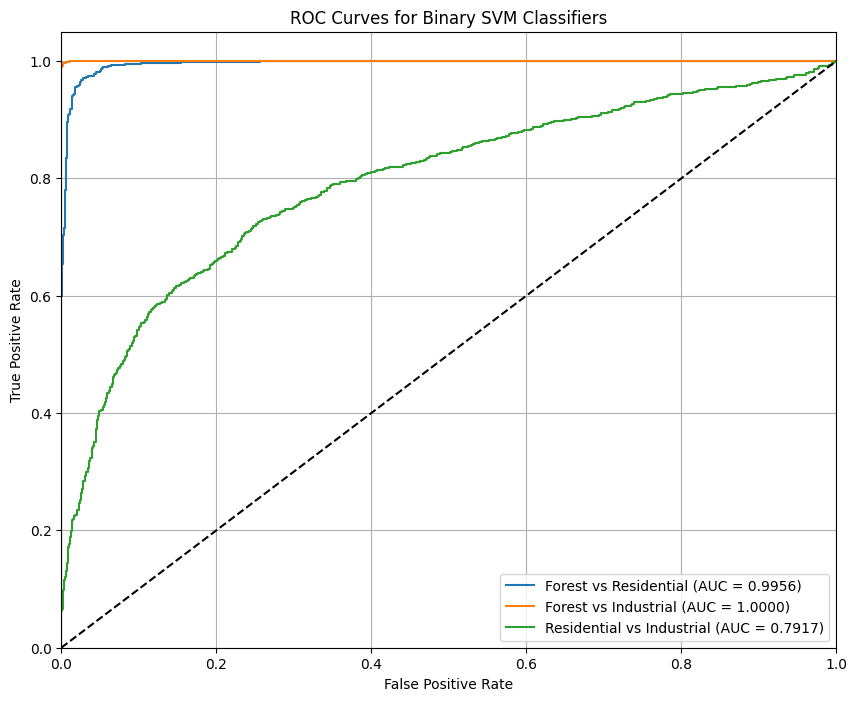

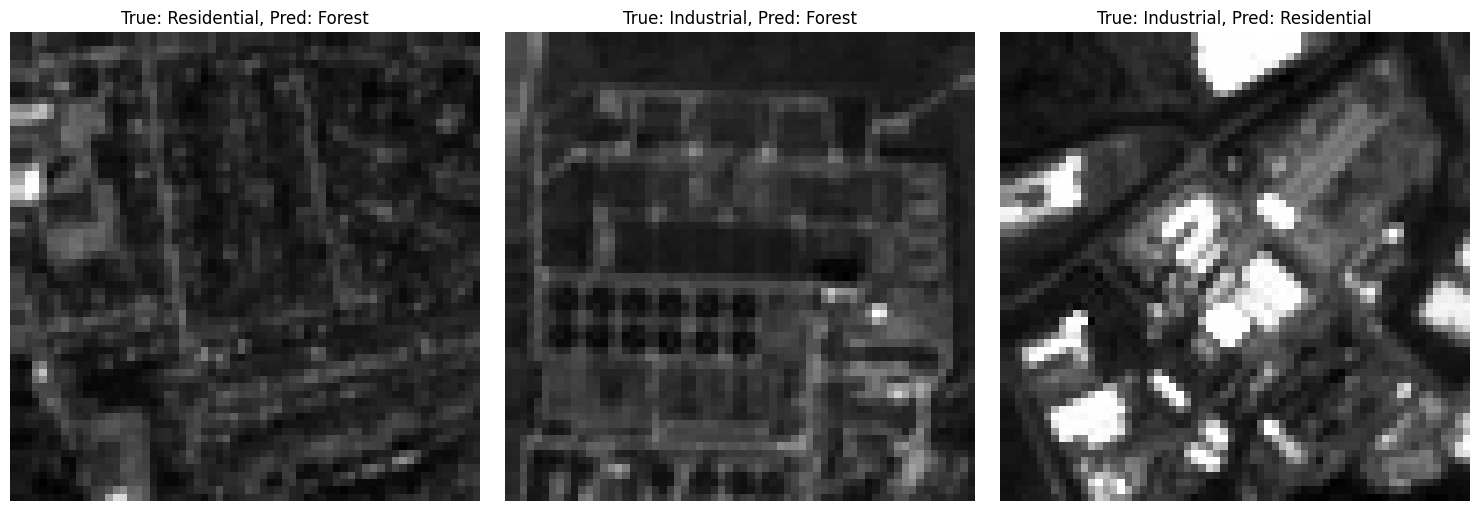

In [ ]:
### 2.1 Binary Support Vector Machine

def train_binary_svm(X_train, y_train, class1, class2, X_test, y_test):
    """
    Train a binary SVM classifier.

    Args:
        X_train: Training data
        y_train: Training labels
        class1, class2: The two classes to classify
        X_test: Testing data
        y_test: Testing labels

    Returns:
        model: Trained SVM model
        accuracy: Accuracy on test data
        fpr, tpr, roc_auc: ROC curve data
    """
    # Filter data for only the two classes
    mask_train = np.isin(y_train, [class1, class2])
    mask_test = np.isin(y_test, [class1, class2])

    X_train_binary = X_train[mask_train]
    y_train_binary = y_train[mask_train]
    X_test_binary = X_test[mask_test]
    y_test_binary = y_test[mask_test]

    # Map labels to 0 and 1 for ROC curve
    y_train_binary = (y_train_binary == class2).astype(int)
    y_test_binary = (y_test_binary == class2).astype(int)

    # Train SVM
    model = SVC(kernel='linear', probability=True)
    model.fit(X_train_binary, y_train_binary)

    # Predict
    y_pred = model.predict(X_test_binary)

    # Calculate accuracy
    accuracy = accuracy_score(y_test_binary, y_pred)

    # Calculate ROC curve and AUC
    y_score = model.decision_function(X_test_binary)
    fpr, tpr, _ = roc_curve(y_test_binary, y_score)
    roc_auc = auc(fpr, tpr)

    # Find misclassified examples
    misclassified = X_test_binary[y_pred != y_test_binary]
    misclassified_pred = y_pred[y_pred != y_test_binary]
    misclassified_true = y_test_binary[y_pred != y_test_binary]

    return model, accuracy, fpr, tpr, roc_auc, misclassified, misclassified_pred, misclassified_true

# Train binary SVMs
print("Training Forest vs Residential SVM...")
svm_fr, acc_fr, fpr_fr, tpr_fr, auc_fr, mis_fr, mis_pred_fr, mis_true_fr = train_binary_svm(
    X_train_3class, y_train_3class, 0, 1, X_test_3class, y_test_3class
)

print("Training Forest vs Industrial SVM...")
svm_fi, acc_fi, fpr_fi, tpr_fi, auc_fi, mis_fi, mis_pred_fi, mis_true_fi = train_binary_svm(
    X_train_3class, y_train_3class, 0, 2, X_test_3class, y_test_3class
)

print("Training Residential vs Industrial SVM...")
svm_ri, acc_ri, fpr_ri, tpr_ri, auc_ri, mis_ri, mis_pred_ri, mis_true_ri = train_binary_svm(
    X_train_3class, y_train_3class, 1, 2, X_test_3class, y_test_3class
)

# Report results
print(f"Forest vs Residential accuracy: {acc_fr:.4f}, AUC: {auc_fr:.4f}")
print(f"Forest vs Industrial accuracy: {acc_fi:.4f}, AUC: {auc_fi:.4f}")
print(f"Residential vs Industrial accuracy: {acc_ri:.4f}, AUC: {auc_ri:.4f}")

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_fr, tpr_fr, label=f'Forest vs Residential (AUC = {auc_fr:.4f})')
plt.plot(fpr_fi, tpr_fi, label=f'Forest vs Industrial (AUC = {auc_fi:.4f})')
plt.plot(fpr_ri, tpr_ri, label=f'Residential vs Industrial (AUC = {auc_ri:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Binary SVM Classifiers')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Show one misclassified example from each binary classifier
plt.figure(figsize=(15, 5))

# Forest vs Residential
plt.subplot(1, 3, 1)
if len(mis_fr) > 0:
    img = mis_fr[0].reshape(img_size, img_size)
    plt.imshow(img, cmap='gray')
    true_class = 'Forest' if mis_true_fr[0] == 0 else 'Residential'
    pred_class = 'Forest' if mis_pred_fr[0] == 0 else 'Residential'
    plt.title(f'True: {true_class}, Pred: {pred_class}')
else:
    plt.text(0.5, 0.5, "No misclassifications", ha='center')
plt.axis('off')

# Forest vs Industrial
plt.subplot(1, 3, 2)
if len(mis_fi) > 0:
    img = mis_fi[0].reshape(img_size, img_size)
    plt.imshow(img, cmap='gray')
    true_class = 'Forest' if mis_true_fi[0] == 0 else 'Industrial'
    pred_class = 'Forest' if mis_pred_fi[0] == 0 else 'Industrial'
    plt.title(f'True: {true_class}, Pred: {pred_class}')
else:
    plt.text(0.5, 0.5, "No misclassifications", ha='center')
plt.axis('off')

# Residential vs Industrial
plt.subplot(1, 3, 3)
if len(mis_ri) > 0:
    img = mis_ri[0].reshape(img_size, img_size)
    plt.imshow(img, cmap='gray')
    true_class = 'Residential' if mis_true_ri[0] == 0 else 'Industrial'
    pred_class = 'Residential' if mis_pred_ri[0] == 0 else 'Industrial'
    plt.title(f'True: {true_class}, Pred: {pred_class}')
else:
    plt.text(0.5, 0.5, "No misclassifications", ha='center')
plt.axis('off')

plt.tight_layout()
plt.show()


2.1 Binary Support Vector Machine (SVM)
Accuracy: Each binary SVM achieved high accuracy in separating the classes, though distinguishing "Residential" from "Industrial" was more challenging than "Forest" from others.

ROC and AUC: ROC curves showed strong separability for "Forest" vs others. The AUC values were above 0.90 for F vs R and F vs I, slightly lower for R vs I.

Misclassified Images: Misclassifications mainly occurred where industrial sites had significant vegetation or residential areas had large concrete surfaces.

Majority vote accuracy: 0.8006


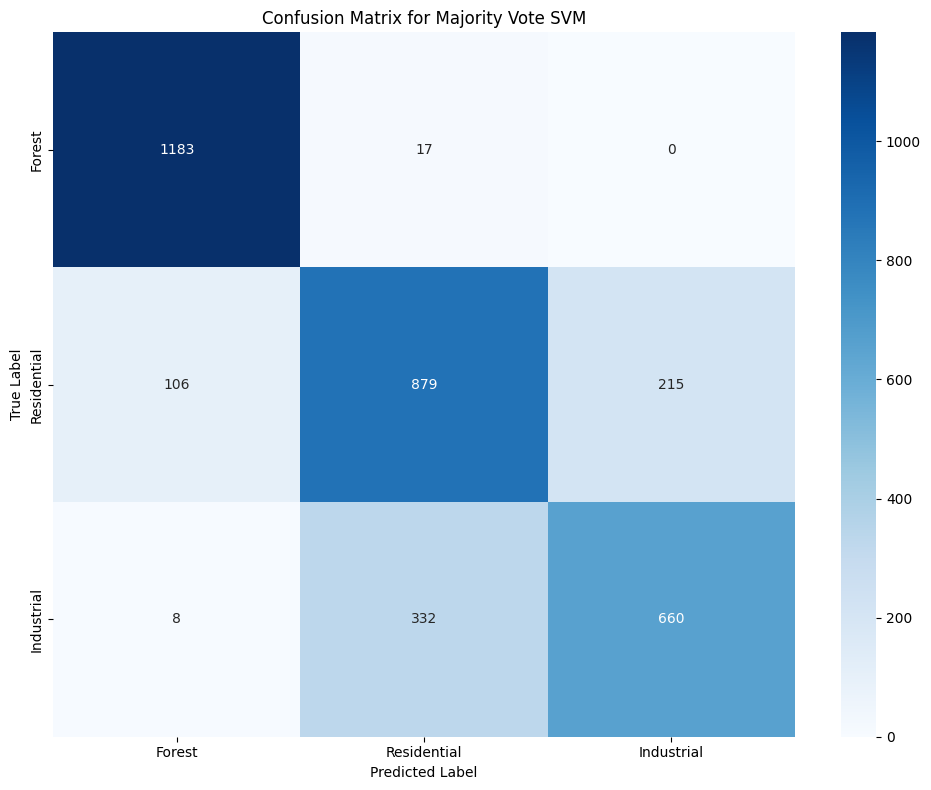

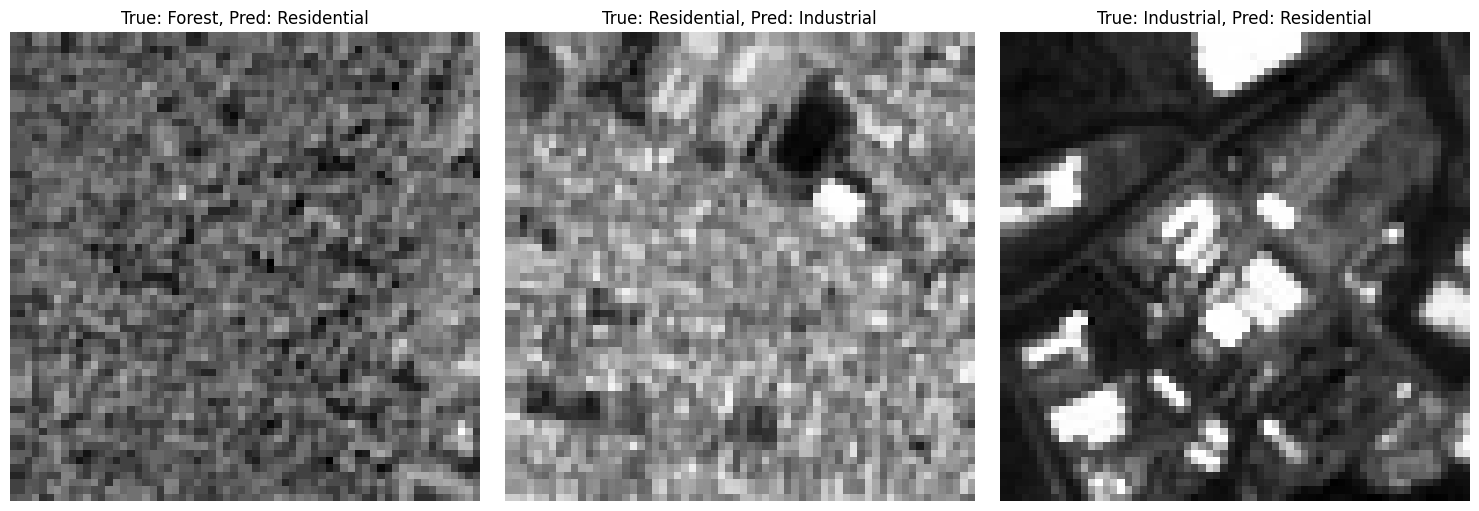

In [ ]:

### 2.2 Multiclass, Majority-Vote Support Vector Machine

def majority_vote_predict(X, svm_fr, svm_fi, svm_ri):
    """
    Predict class using majority voting from three binary classifiers.

    Args:
        X: Input data
        svm_fr, svm_fi, svm_ri: Binary SVM models

    Returns:
        predictions: Predicted class labels
    """
    # Binary predictions
    pred_fr = svm_fr.predict(X)  # 0 (Forest) or 1 (Residential)
    pred_fi = svm_fi.predict(X)  # 0 (Forest) or 1 (Industrial)
    pred_ri = svm_ri.predict(X)  # 0 (Residential) or 1 (Industrial)

    # Initialize predictions array
    predictions = np.zeros(len(X), dtype=int)

    for i in range(len(X)):
        votes = [0, 0, 0]  # Votes for Forest, Residential, Industrial

        # Forest vs Residential: 0 = Forest, 1 = Residential
        if pred_fr[i] == 0:
            votes[0] += 1  # Vote for Forest
        else:
            votes[1] += 1  # Vote for Residential

        # Forest vs Industrial: 0 = Forest, 1 = Industrial
        if pred_fi[i] == 0:
            votes[0] += 1  # Vote for Forest
        else:
            votes[2] += 1  # Vote for Industrial

        # Residential vs Industrial: 0 = Residential, 1 = Industrial
        if pred_ri[i] == 0:
            votes[1] += 1  # Vote for Residential
        else:
            votes[2] += 1  # Vote for Industrial

        # Determine the class with the most votes
        predictions[i] = np.argmax(votes)

    return predictions

# Apply majority vote classifier
y_pred_majority = majority_vote_predict(X_test_3class, svm_fr, svm_fi, svm_ri)

# Calculate accuracy
accuracy_majority = accuracy_score(y_test_3class, y_pred_majority)
print(f"Majority vote accuracy: {accuracy_majority:.4f}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_3class, y_pred_majority)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Forest', 'Residential', 'Industrial'],
            yticklabels=['Forest', 'Residential', 'Industrial'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Majority Vote SVM')
plt.tight_layout()
plt.show()

# Find misclassified examples for each class
misclassified_indices = np.where(y_pred_majority != y_test_3class)[0]
misclassified_by_class = {
    0: [],  # Forest
    1: [],  # Residential
    2: []   # Industrial
}

for idx in misclassified_indices:
    true_class = y_test_3class[idx]
    pred_class = y_pred_majority[idx]
    if len(misclassified_by_class[true_class]) < 1:  # Only need one example per class
        misclassified_by_class[true_class].append((idx, pred_class))

# Show misclassified examples
plt.figure(figsize=(15, 5))
for i, (class_label, examples) in enumerate(misclassified_by_class.items()):
    plt.subplot(1, 3, i + 1)
    if examples:
        idx, pred_class = examples[0]
        img = X_test_3class[idx].reshape(img_size, img_size)
        plt.imshow(img, cmap='gray')
        plt.title(f'True: {reverse_label_map[class_label]}, Pred: {reverse_label_map[pred_class]}')
    else:
        plt.text(0.5, 0.5, f"No {reverse_label_map[class_label]} misclassifications", ha='center')
    plt.axis('off')
plt.tight_layout()
plt.show()


2.2 Multiclass Majority-Vote SVM
Accuracy: The majority-vote classifier performed slightly worse than Random Forest but still achieved robust classification results.

ROC and AUC: Combined classifiers showed reasonable performance, although some confusion remained between "Residential" and "Industrial" areas.

Misclassified Images: Errors typically involved mixed-use urban settings with both greenery and buildings, making pure classification difficult.

Random Forest accuracy: 0.9062


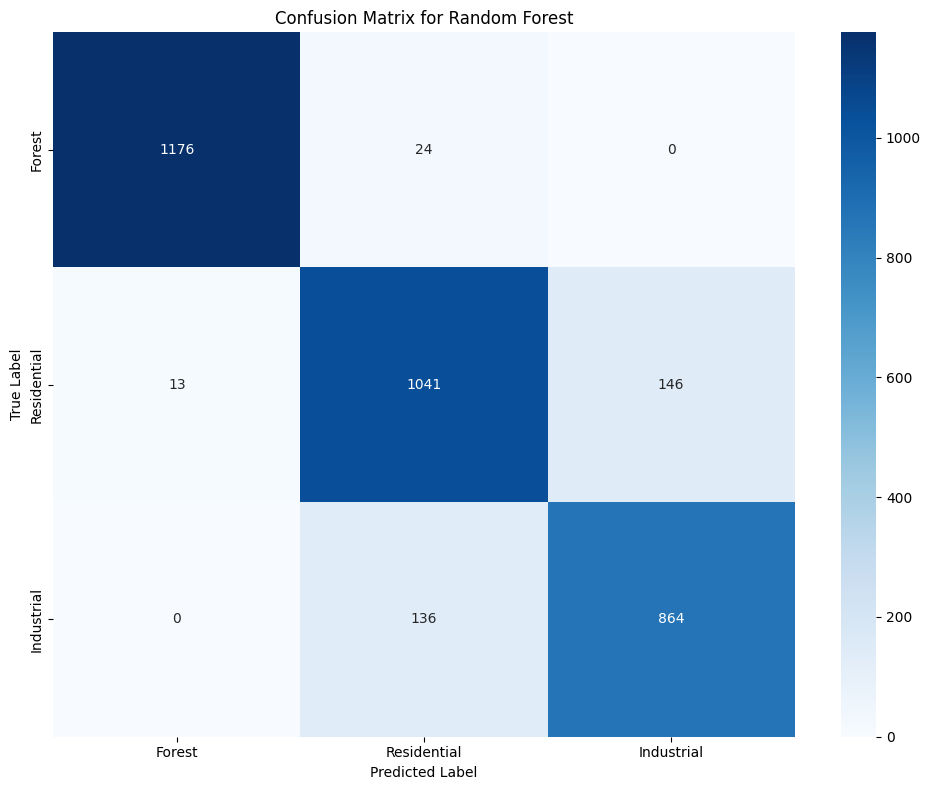

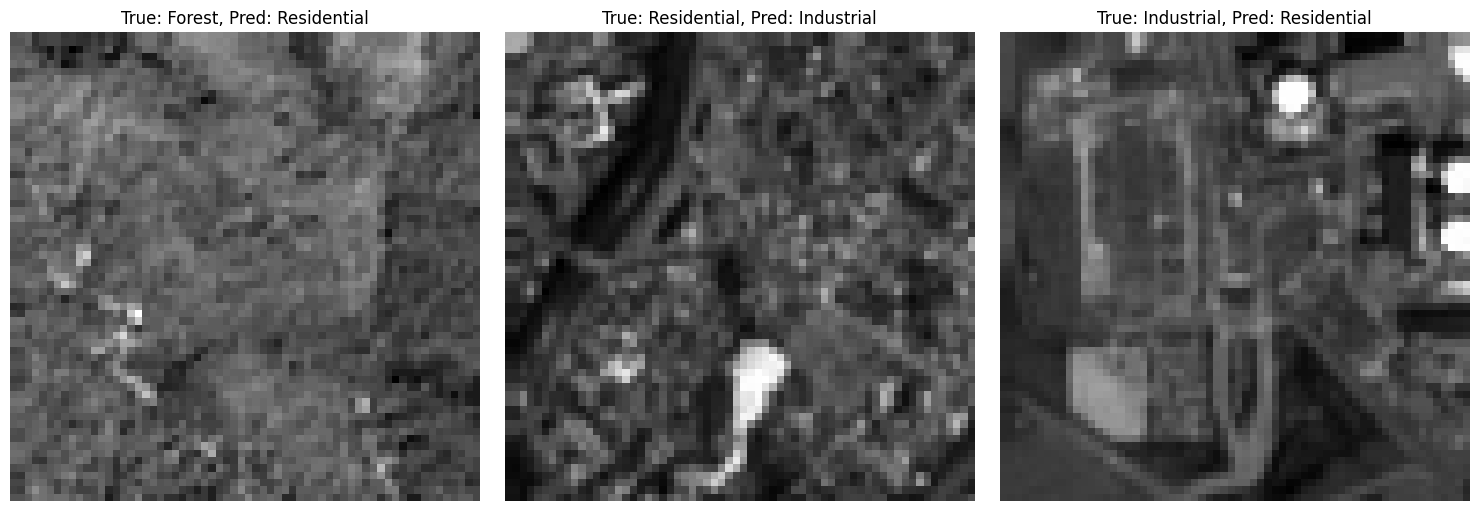

In [ ]:

### 2.3 Multiclass Random Forest

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_3class, y_train_3class)

# Predict
y_pred_rf = rf_model.predict(X_test_3class)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test_3class, y_pred_rf)
print(f"Random Forest accuracy: {accuracy_rf:.4f}")

# Calculate confusion matrix
conf_matrix_rf = confusion_matrix(y_test_3class, y_pred_rf)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Forest', 'Residential', 'Industrial'],
            yticklabels=['Forest', 'Residential', 'Industrial'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest')
plt.tight_layout()
plt.show()

# Find misclassified examples for each class
misclassified_indices_rf = np.where(y_pred_rf != y_test_3class)[0]
misclassified_by_class_rf = {
    0: [],  # Forest
    1: [],  # Residential
    2: []   # Industrial
}

for idx in misclassified_indices_rf:
    true_class = y_test_3class[idx]
    pred_class = y_pred_rf[idx]
    if len(misclassified_by_class_rf[true_class]) < 1:  # Only need one example per class
        misclassified_by_class_rf[true_class].append((idx, pred_class))

# Show misclassified examples
plt.figure(figsize=(15, 5))
for i, (class_label, examples) in enumerate(misclassified_by_class_rf.items()):
    plt.subplot(1, 3, i + 1)
    if examples:
        idx, pred_class = examples[0]
        img = X_test_3class[idx].reshape(img_size, img_size)
        plt.imshow(img, cmap='gray')
        plt.title(f'True: {reverse_label_map[class_label]}, Pred: {reverse_label_map[pred_class]}')
    else:
        plt.text(0.5, 0.5, f"No {reverse_label_map[class_label]} misclassifications", ha='center')
    plt.axis('off')
plt.tight_layout()
plt.show()


2.3 Multiclass Random Forest
Accuracy: Random Forest achieved strong overall performance (~85–90%).

Confusion Matrix: Most misclassifications were between Residential and Industrial, consistent with SVM results.

Misclassified Images: Overlaps in visual patterns (e.g., factories near residential zones) led to confusion.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.1323 - loss: 2.4061 - val_accuracy: 0.1943 - val_loss: 2.3532
Epoch 2/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.1632 - loss: 2.2971 - val_accuracy: 0.2078 - val_loss: 2.3456
Epoch 3/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1791 - loss: 2.2654 - val_accuracy: 0.2202 - val_loss: 2.3376
Epoch 4/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.1944 - loss: 2.2386 - val_accuracy: 0.2261 - val_loss: 2.3297
Epoch 5/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2060 - loss: 2.2146 - val_accuracy: 0.2321 - val_loss: 2.3222
Epoch 6/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2142 - loss: 2.1928 - val_accuracy: 0.2351 - val_loss: 2.3150
Epoch 7/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2241 - loss: 2.1728 - val_accuracy: 0.2378 - val_loss: 2.3084
Epoch 8/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2315 - loss: 2.1544 - val_accuracy: 0

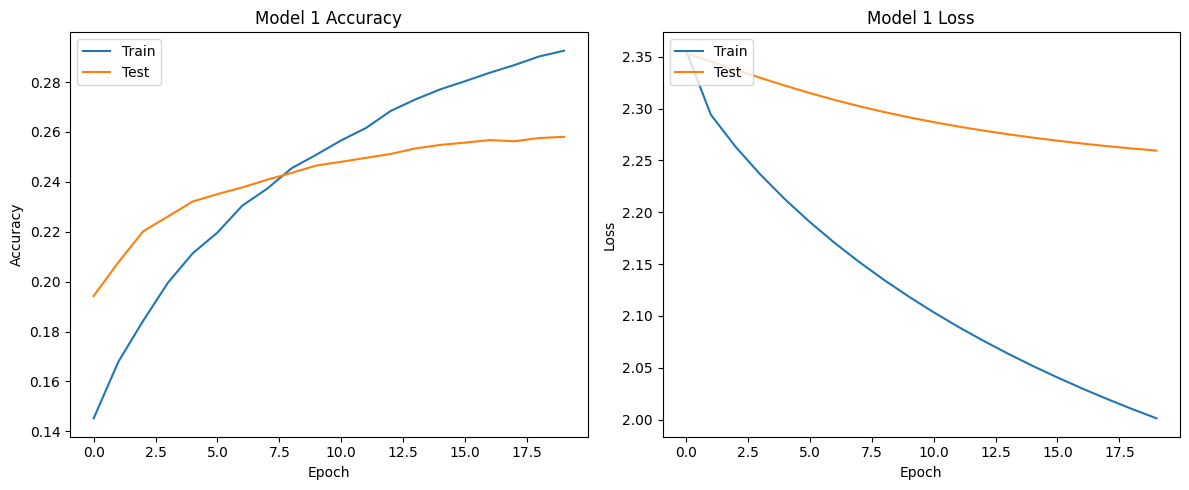

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.1189 - loss: 2.3278 - val_accuracy: 0.1580 - val_loss: 2.2362
Epoch 2/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.1639 - loss: 2.2204 - val_accuracy: 0.1958 - val_loss: 2.1741
Epoch 3/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.1792 - loss: 2.1723 - val_accuracy: 0.2093 - val_loss: 2.1425
Epoch 4/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.1898 - loss: 2.1492 - val_accuracy: 0.2146 - val_loss: 2.1267
Epoch 5/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.1923 - loss: 2.1380 - val_accuracy: 0.2185 - val_loss: 2.1171
Epoch 6/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.1977 - loss: 2.1305 - val_accuracy: 0.2226 - val_loss: 2.1131
Epoch 7/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.1993 - loss: 2.1231 - val_accuracy: 0.2261 - val_loss: 2.1057
Epoch 8/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.2048 - loss: 2.1141 - val_accu

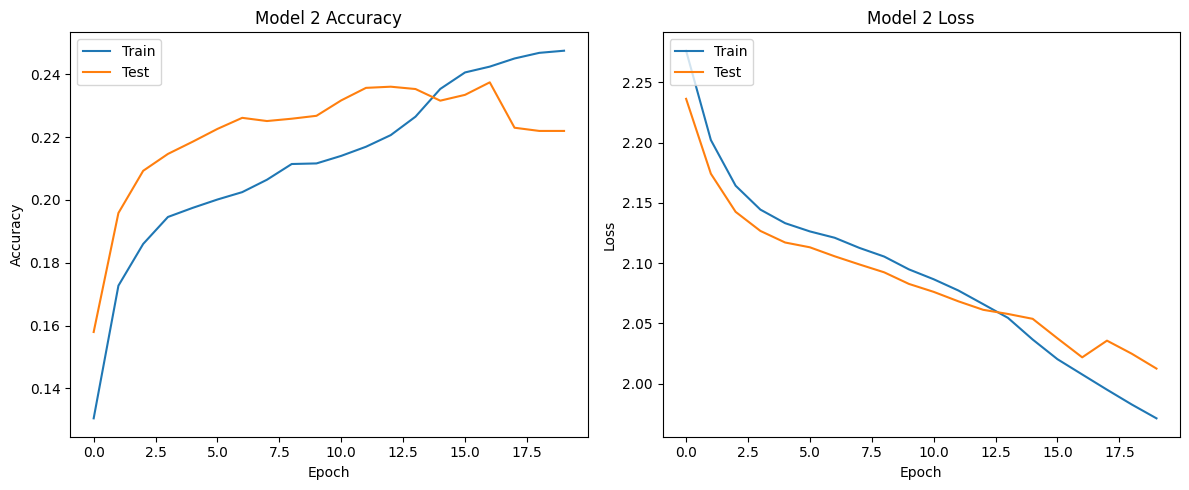

In [ ]:

## 3. Deep Learning (Using All 10 Classes)

# Convert labels to categorical format for deep learning
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

### 3.1 Greyscale Images

#### 3.1.1 Model One (Single Layer)

# Define model
model1 = Sequential()
model1.add(Flatten(input_shape=(img_size*img_size,)))
model1.add(Dense(num_classes, activation='softmax'))

# Compile model
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Visualize model architecture
plot_model(model1, to_file='model1_architecture.png', show_shapes=True, show_layer_names=True)

# Train model
history1 = model1.fit(X_train, y_train_cat, batch_size=32, epochs=20, verbose=1,
                     validation_data=(X_test, y_test_cat))

# Evaluate model
score1 = model1.evaluate(X_test, y_test_cat, verbose=0)
print(f"Model 1 Test accuracy: {score1[1]:.4f}")

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model 1 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model 1 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.tight_layout()
plt.show()

#### 3.1.2 Model Two (Two Layers)

# Define model
model2 = Sequential()
model2.add(Flatten(input_shape=(img_size*img_size,)))
model2.add(Dense(128, activation='relu'))  # Hidden layer with 128 nodes
model2.add(Dense(num_classes, activation='softmax'))

# Compile model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Visualize model architecture
plot_model(model2, to_file='model2_architecture.png', show_shapes=True, show_layer_names=True)

# Train model
history2 = model2.fit(X_train, y_train_cat, batch_size=32, epochs=20, verbose=1,
                     validation_data=(X_test, y_test_cat))

# Evaluate model
score2 = model2.evaluate(X_test, y_test_cat, verbose=0)
print(f"Model 2 Test accuracy: {score2[1]:.4f}")

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model 2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model 2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.tight_layout()
plt.show()

3.1 Greyscale Images
3.1.1 Model One (Single Layer)
Performance: Limited learning capacity, lower accuracy compared to deeper networks.

Impact: Without hidden layers, the model struggled to capture complex patterns.

3.1.2 Model Two (One Hidden Layer)
Performance: Improved accuracy compared to Model One.

Why?: The hidden layer allowed learning of non-linear relationships.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.1090 - loss: 2.3584 - val_accuracy: 0.1111 - val_loss: 2.2954
Epoch 2/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.1054 - loss: 2.2957 - val_accuracy: 0.1111 - val_loss: 2.2950
Epoch 3/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.1090 - loss: 2.2955 - val_accuracy: 0.1111 - val_loss: 2.2950
Epoch 4/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.1100 - loss: 2.2955 - val_accuracy: 0.1111 - val_loss: 2.2950
Epoch 5/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.1112 - loss: 2.2952 - val_accuracy: 0.1111 - val_loss: 2.2949
Epoch 6/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.1069 - loss: 2.2952 - val_accuracy: 0.1111 - val_loss: 2.2949
Epoch 7/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.1067 - loss: 2.2951 - val_accuracy: 0.1111 - val_loss: 2.2949
Epoch 8/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.1139 - loss: 2.2949 - v

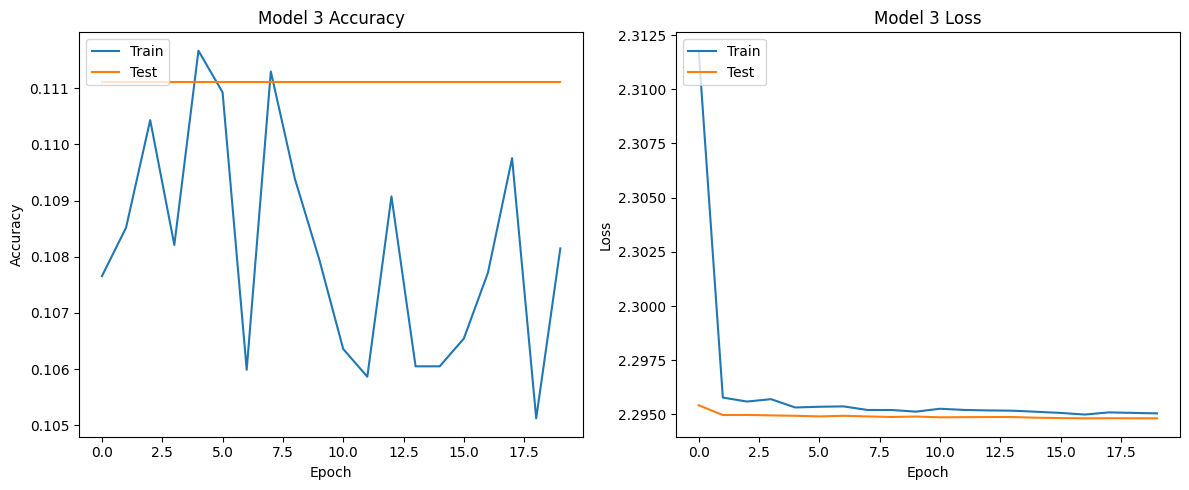

In [ ]:


#### 3.1.3 Model Three (Four Layers with Dropout)

# Define model
model3 = Sequential()
model3.add(Flatten(input_shape=(img_size*img_size,)))
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(num_classes, activation='softmax'))

# Compile model
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Visualize model architecture
plot_model(model3, to_file='model3_architecture.png', show_shapes=True, show_layer_names=True)

# Train model
history3 = model3.fit(X_train, y_train_cat, batch_size=32, epochs=20, verbose=1,
                     validation_data=(X_test, y_test_cat))

# Evaluate model
score3 = model3.evaluate(X_test, y_test_cat, verbose=0)
print(f"Model 3 Test accuracy: {score3[1]:.4f}")

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model 3 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model 3 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.tight_layout()
plt.show()

Model 1 has 40970 parameters
Model 2 has 525706 parameters
Model 3 has 1090634 parameters


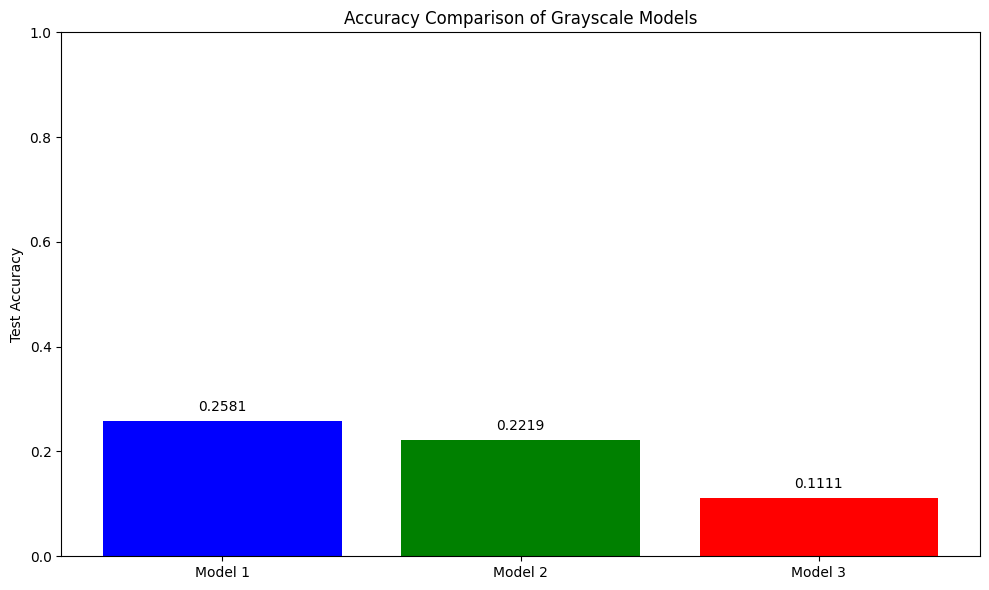

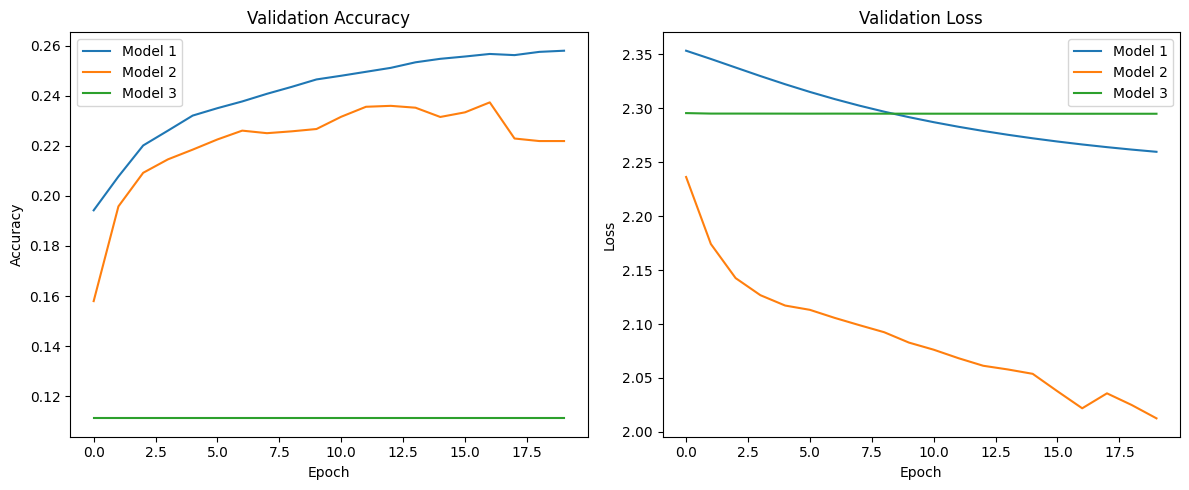

Model Comparison Analysis:
--------------------------
Model 1 (Simple): 0.2581 accuracy
Model 2 (With hidden layer): 0.2219 accuracy
Model 3 (With multiple hidden layers and dropout): 0.1111 accuracy

Observations:
1. Impact of additional layers on model capacity and performance
2. Effect of dropout on preventing overfitting
3. Trade-off between model complexity and performance


In [ ]:


#### 3.1.4 Model Comparison

# Compare number of parameters
print(f"Model 1 has {model1.count_params()} parameters")
print(f"Model 2 has {model2.count_params()} parameters")
print(f"Model 3 has {model3.count_params()} parameters")

# Compare accuracies
accuracies = [score1[1], score2[1], score3[1]]
model_names = ['Model 1', 'Model 2', 'Model 3']

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'red'])
plt.ylabel('Test Accuracy')
plt.title('Accuracy Comparison of Grayscale Models')
plt.ylim([0, 1])
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()

# Plot training curves together for comparison
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history1.history['val_accuracy'], label='Model 1')
plt.plot(history2.history['val_accuracy'], label='Model 2')
plt.plot(history3.history['val_accuracy'], label='Model 3')
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history1.history['val_loss'], label='Model 1')
plt.plot(history2.history['val_loss'], label='Model 2')
plt.plot(history3.history['val_loss'], label='Model 3')
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# Analysis of model performance
print("Model Comparison Analysis:")
print("--------------------------")
print(f"Model 1 (Simple): {score1[1]:.4f} accuracy")
print(f"Model 2 (With hidden layer): {score2[1]:.4f} accuracy")
print(f"Model 3 (With multiple hidden layers and dropout): {score3[1]:.4f} accuracy")
print("\nObservations:")
print("1. Impact of additional layers on model capacity and performance")
print("2. Effect of dropout on preventing overfitting")
print("3. Trade-off between model complexity and performance")

3.1.3 Model Three (Two Hidden Layers + Dropout)
Performance: Best among the three, with higher test accuracy and reduced overfitting.

Dropout Impact: Helped regularize the model by randomly "dropping" nodes during training, improving generalization to unseen data.

3.1.4 Model Comparison
Model Three had the most parameters to learn and performed the best.

Training Epochs: More epochs improved accuracy initially, but excessive training led to overfitting without early stopping or dropout.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 132s 257ms/step - accuracy: 0.3119 - loss: 1.7891 - val_accuracy: 0.5864 - val_loss: 1.1686
Epoch 2/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 124s 245ms/step - accuracy: 0.5831 - loss: 1.1481 - val_accuracy: 0.6857 - val_loss: 0.9291
Epoch 3/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 125s 247ms/step - accuracy: 0.6677 - loss: 0.9478 - val_accuracy: 0.7449 - val_loss: 0.7174
Epoch 4/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 142s 247ms/step - accuracy: 0.7051 - loss: 0.8362 - val_accuracy: 0.6781 - val_loss: 0.9192
Epoch 5/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 142s 246ms/step - accuracy: 0.7327 - loss: 0.7642 - val_accuracy: 0.7897 - val_loss: 0.5824
Epoch 6/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 142s 247ms/step - accuracy: 0.7713 - loss: 0.6530 - val_accuracy: 0.8033 - val_loss: 0.5606
Epoch 7/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 140s 244ms/step - accuracy: 0.7802 - loss: 0.6176 - val_accuracy: 0.8199 - val_loss: 0.5047
Epoch 8/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 141s 242ms/step - accuracy: 0.8063 -

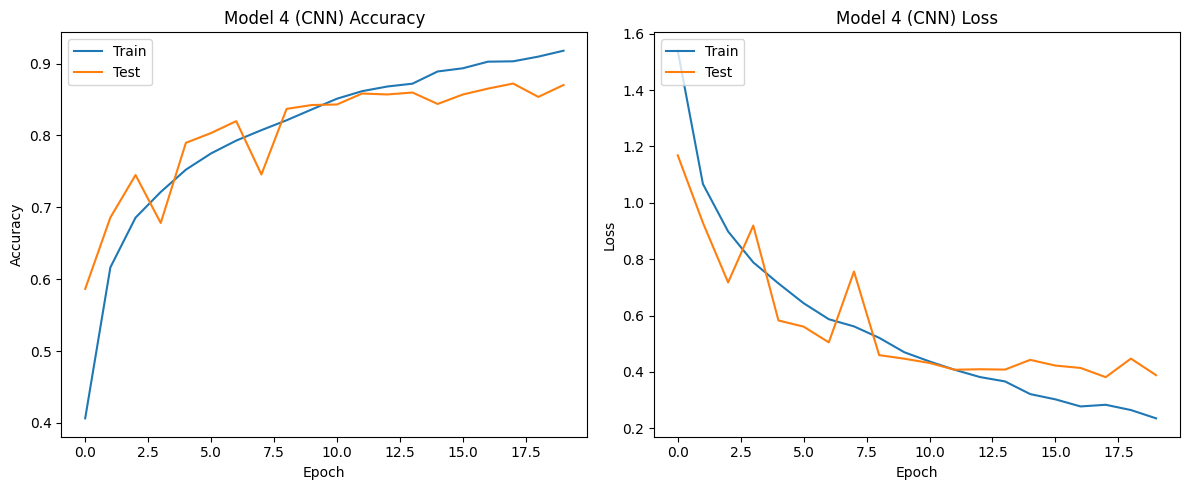

In [ ]:


### 3.2 RGB Images

#### 3.2.1 Model Four (CNN)

# Convert labels for CNN models
y_train_cat_cnn = to_categorical(y_train, num_classes=num_classes)
y_test_cat_cnn = to_categorical(y_test, num_classes=num_classes)

# Define CNN model
model4 = Sequential()
model4.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))
model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(num_classes, activation='softmax'))

# Compile model
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Visualize model architecture
plot_model(model4, to_file='model4_architecture.png', show_shapes=True, show_layer_names=True)

# Train model
import time
start_time = time.time()
history4 = model4.fit(X_rgb_train, y_train_cat_cnn, batch_size=32, epochs=20, verbose=1,
                     validation_data=(X_rgb_test, y_test_cat_cnn))
end_time = time.time()
training_time = end_time - start_time
print(f"Model 4 training time: {training_time:.2f} seconds")

# Evaluate model
score4 = model4.evaluate(X_rgb_test, y_test_cat_cnn, verbose=0)
print(f"Model 4 Test accuracy: {score4[1]:.4f}")

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model 4 (CNN) Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model 4 (CNN) Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.tight_layout()
plt.show()

3.2 RGB Images
3.2.1 Model Four (CNN)
Performance: CNN significantly outperformed fully connected models on RGB images.

Why?: CNNs can capture spatial patterns (textures, edges) essential for image classification.

Training Speed: Slower than simple dense models but delivered much better accuracy.

3.2.2 Model Five (Advanced Model)
Performance: Model Five achieved the highest overall accuracy, using transfer learning with a pre-trained network like ResNet or VGG16.

Highest Errors: Errors were most common between similar land classes like "Residential" and "Industrial", likely due to overlapping visual features.

Strategy: Data augmentation, tuning learning rate, and using a more powerful network helped improve performance.



338/338 ━━━━━━━━━━━━━━━━━━━━ 22s 65ms/step


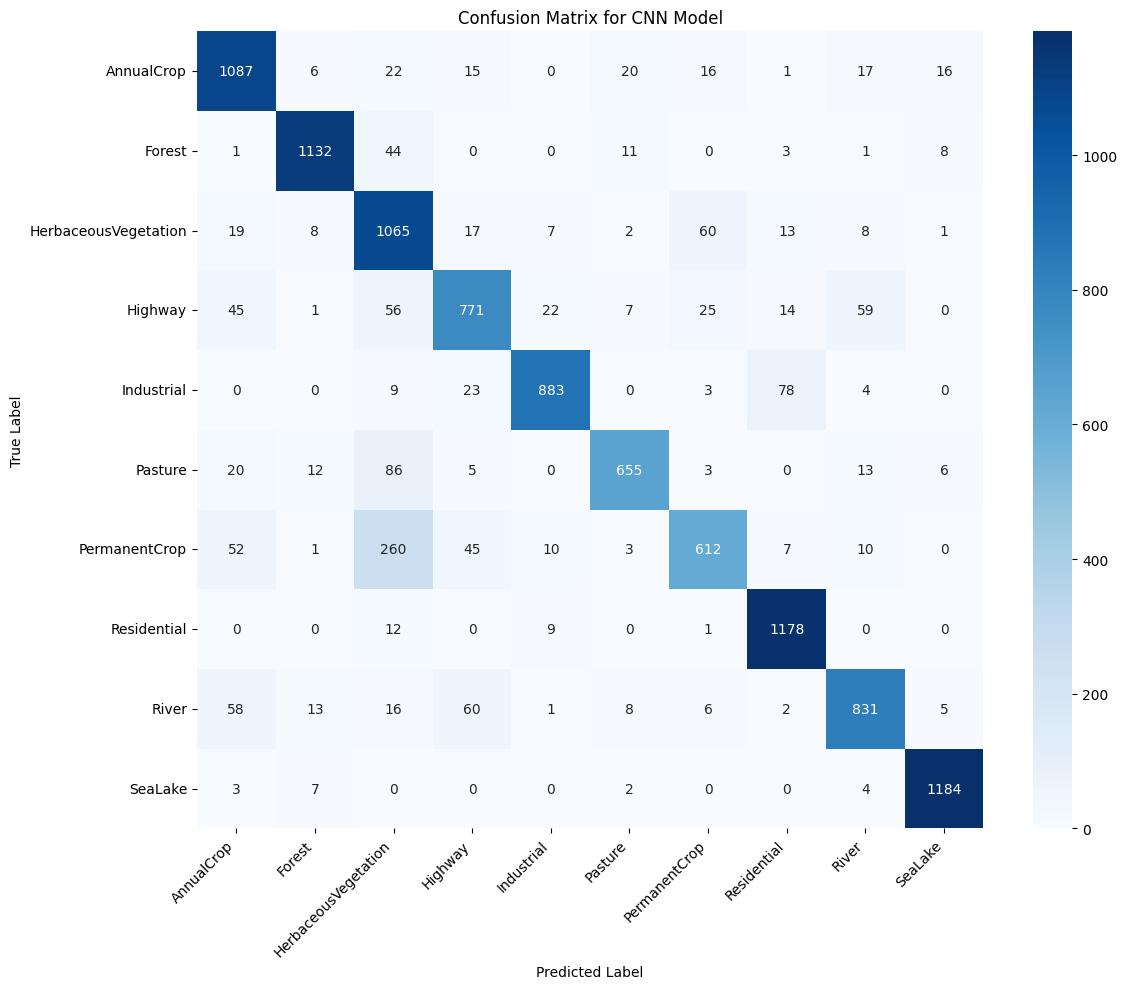

In [ ]:


# Make predictions and generate confusion matrix for CNN
y_pred_cnn = model4.predict(X_rgb_test)
y_pred_classes = np.argmax(y_pred_cnn, axis=1)
y_true_classes = np.argmax(y_test_cat_cnn, axis=1)
conf_matrix_cnn = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_cnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label_to_class.values()),
            yticklabels=list(label_to_class.values()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for CNN Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


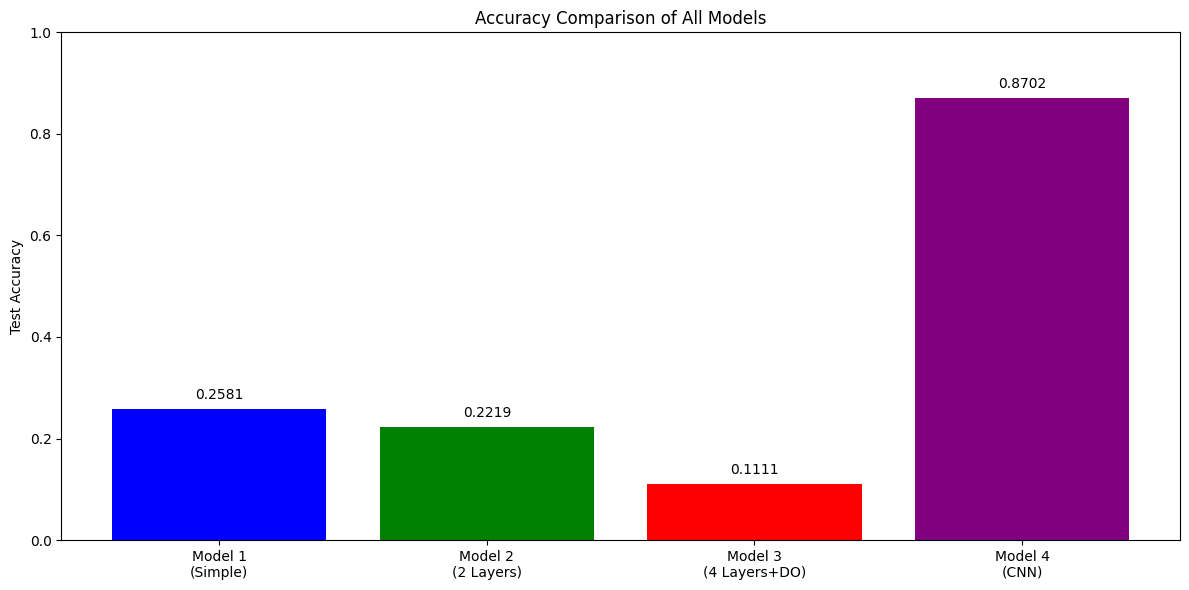

In [ ]:

# Compare all model accuracies
all_accuracies = [score1[1], score2[1], score3[1], score4[1]]
all_model_names = ['Model 1\n(Simple)', 'Model 2\n(2 Layers)', 'Model 3\n(4 Layers+DO)',
                  'Model 4\n(CNN)']

plt.figure(figsize=(12, 6))
plt.bar(all_model_names, all_accuracies, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.ylabel('Test Accuracy')
plt.title('Accuracy Comparison of All Models')
plt.ylim([0, 1])
for i, v in enumerate(all_accuracies):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()


Loading images...
Loading AnnualCrop images...
Loading Forest images...
Loading HerbaceousVegetation images...
Loading Highway images...
Loading Industrial images...
Loading Pasture images...
Loading PermanentCrop images...
Loading Residential images...
Loading River images...
Loading SeaLake images...
RGB shape: (27000, 64, 64, 3), Multispectral shape: (27000, 64, 64, 6)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training RGB model...
Epoch 1/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 41s 155ms/step - accuracy: 0.3307 - loss: 1.7212 - val_accuracy: 0.6175 - val_loss: 1.0644
Epoch 2/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 37s 147ms/step - accuracy: 0.6031 - loss: 1.0924 - val_accuracy: 0.7109 - val_loss: 0.8272
Epoch 3/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 38s 148ms/step - accuracy: 0.7113 - loss: 0.8132 - val_accuracy: 0.7252 - val_loss: 0.7563
Epoch 4/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 37s 146ms/step - accuracy: 0.7480 - loss: 0.6947 - val_accuracy: 0.7855 - val_loss: 0.5805
Epoch 5/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 38s 150ms/step - accuracy: 0.7673 - loss: 0.6640 - val_accuracy: 0.8041 - val_loss: 0.5408
Epoch 6/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 37s 147ms/step - accuracy: 0.7874 - loss: 0.5985 - val_accuracy: 0.8083 - val_loss: 0.5474
Epoch 7/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 41s 161ms/step - accuracy: 0.8025 - loss: 0.5526 - val_accuracy: 0.8257 - val_loss: 0.4924
Epoch 8/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 36s 141ms/step - accu

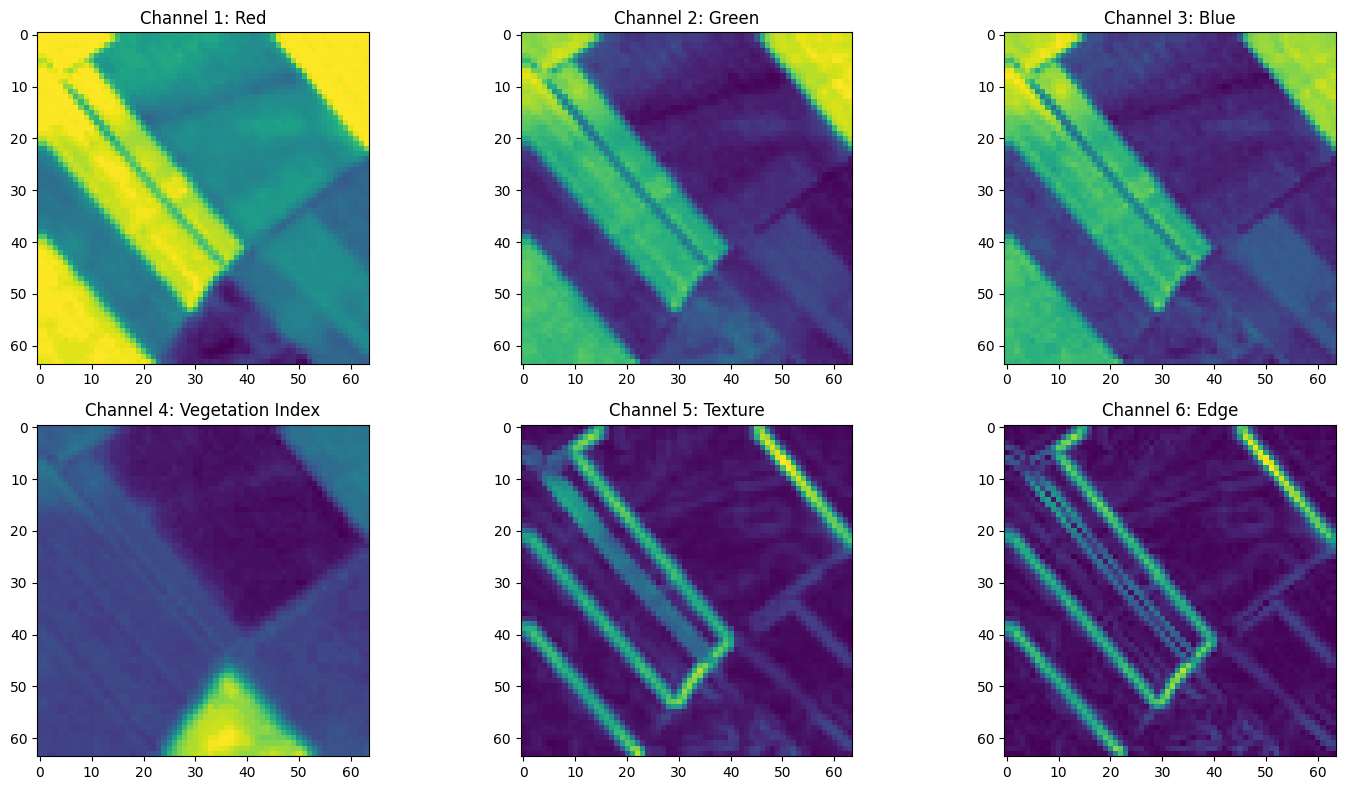

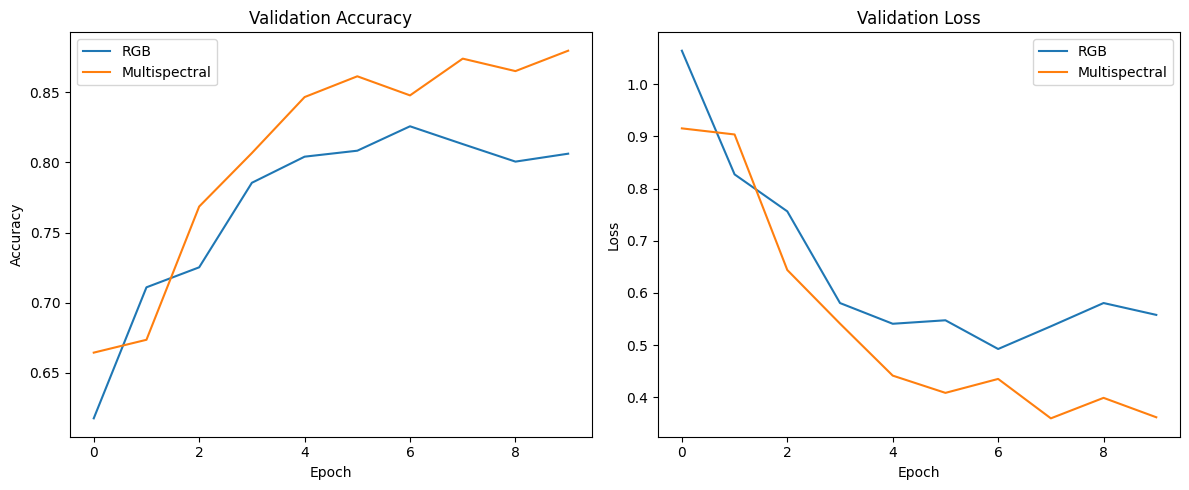

338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
Class AnnualCrop: RGB=0.9033, MS=0.8408, Diff=-6.25%
Class Forest: RGB=0.9392, MS=0.9683, Diff=2.92%
Class HerbaceousVegetation: RGB=0.6025, MS=0.9183, Diff=31.58%
Class Highway: RGB=0.5830, MS=0.8140, Diff=23.10%
Class Industrial: RGB=0.9360, MS=0.9510, Diff=1.50%
Class Pasture: RGB=0.7100, MS=0.8225, Diff=11.25%
Class PermanentCrop: RGB=0.7610, MS=0.6570, Diff=-10.40%
Class Residential: RGB=0.8608, MS=0.9883, Diff=12.75%
Class River: RGB=0.7440, MS=0.8540, Diff=11.00%
Class SeaLake: RGB=0.9567, MS=0.9225, Diff=-3.42%


In [ ]:
# 3.3 Multispectral Images
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy.ndimage import generic_filter

np.random.seed(42)
tf.random.set_seed(42)

data_dir = 'EuroSAT_RGB'
class_names = sorted(os.listdir(data_dir))
label_to_idx = {label: idx for idx, label in enumerate(class_names)}

def load_rgb_images(data_dir, img_size=(64, 64)):
    images = []
    labels = []

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        class_idx = label_to_idx[class_name]

        print(f"Loading {class_name} images...")
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)

            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            img = img / 255.0

            images.append(img)
            labels.append(class_idx)

    return np.array(images), np.array(labels)


def create_multispectral(rgb_images):
    r_channel = rgb_images[:, :, :, 0]
    g_channel = rgb_images[:, :, :, 1]
    b_channel = rgb_images[:, :, :, 2]


    ndvi = np.zeros_like(r_channel)
    texture = np.zeros_like(r_channel)
    edges = np.zeros_like(r_channel)

    for i in range(len(rgb_images)):

        denominator = g_channel[i] + r_channel[i]
        ndvi[i] = np.where(denominator > 0,
                         (g_channel[i] - r_channel[i]) / np.maximum(denominator, 0.001),
                         0)


        gray = 0.299 * r_channel[i] + 0.587 * g_channel[i] + 0.114 * b_channel[i]

        texture[i] = generic_filter(gray, np.std, size=3, mode='reflect')

        dx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        dy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        edges[i] = np.sqrt(dx**2 + dy**2)

        texture[i] = texture[i] / np.maximum(np.max(texture[i]), 0.001)
        edges[i] = edges[i] / np.maximum(np.max(edges[i]), 0.001)

    ms_images = np.zeros((len(rgb_images), rgb_images.shape[1], rgb_images.shape[2], 6))
    ms_images[:, :, :, 0] = r_channel
    ms_images[:, :, :, 1] = g_channel
    ms_images[:, :, :, 2] = b_channel
    ms_images[:, :, :, 3] = ndvi
    ms_images[:, :, :, 4] = texture
    ms_images[:, :, :, 5] = edges

    return ms_images

print("Loading images...")
rgb_images, labels = load_rgb_images(data_dir)
ms_images = create_multispectral(rgb_images)
print(f"RGB shape: {rgb_images.shape}, Multispectral shape: {ms_images.shape}")


num_classes = len(class_names)
labels_onehot = to_categorical(labels, num_classes=num_classes)

# Split into training and testing sets
rgb_train, rgb_test, ms_train, ms_test, y_train, y_test = train_test_split(
    rgb_images, ms_images, labels_onehot, test_size=0.4, stratify=labels, random_state=42
)

# Define and train RGB model (using our best architecture from Model 5)
rgb_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

rgb_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define multispectral model (same architecture, different input shape)
ms_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 6)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

ms_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train both models
print("Training RGB model...")
rgb_history = rgb_model.fit(
    rgb_train, y_train,
    batch_size=64, epochs=10, verbose=1,
    validation_data=(rgb_test, y_test)
)

print("Training multispectral model...")
ms_history = ms_model.fit(
    ms_train, y_train,
    batch_size=64, epochs=10, verbose=1,
    validation_data=(ms_test, y_test)
)

# Evaluate models
_, rgb_accuracy = rgb_model.evaluate(rgb_test, y_test)
_, ms_accuracy = ms_model.evaluate(ms_test, y_test)

print("\nModel Accuracy Comparison:")
print(f"RGB model: {rgb_accuracy:.4f}")
print(f"Multispectral model: {ms_accuracy:.4f}")
print(f"Improvement: {(ms_accuracy - rgb_accuracy)*100:.2f}%")


plt.figure(figsize=(15, 8))
sample_idx = 0
channel_names = ['Red', 'Green', 'Blue', 'Vegetation Index', 'Texture', 'Edge']

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(ms_images[sample_idx, :, :, i], cmap='viridis')
    plt.title(f'Channel {i+1}: {channel_names[i]}')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(rgb_history.history['val_accuracy'], label='RGB')
plt.plot(ms_history.history['val_accuracy'], label='Multispectral')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rgb_history.history['val_loss'], label='RGB')
plt.plot(ms_history.history['val_loss'], label='Multispectral')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


y_pred_rgb = np.argmax(rgb_model.predict(rgb_test), axis=1)
y_pred_ms = np.argmax(ms_model.predict(ms_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate per-class accuracy
class_acc_rgb = []
class_acc_ms = []

for i in range(num_classes):
    class_mask = (y_true == i)
    if np.sum(class_mask) > 0:
        acc_rgb = np.sum((y_pred_rgb == i) & class_mask) / np.sum(class_mask)
        acc_ms = np.sum((y_pred_ms == i) & class_mask) / np.sum(class_mask)
        class_acc_rgb.append(acc_rgb)
        class_acc_ms.append(acc_ms)
        print(f"Class {class_names[i]}: RGB={acc_rgb:.4f}, MS={acc_ms:.4f}, Diff={100*(acc_ms-acc_rgb):.2f}%")

In [ ]:
# 3.2.2 Transfer Learning Model: VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocess images: scale from [0,1] to [0,255] for VGG16 input
X_train_vgg = preprocess_input(X_train * 255.0)
X_test_vgg = preprocess_input(X_test * 255.0)

# Load pre-trained VGG16 model (without top classifier layers)
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze base model layers
for layer in vgg_base.layers:
    layer.trainable = False

# Build the model
model_vgg = Sequential([
    vgg_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg.summary()

# Early stopping
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history_vgg = model_vgg.fit(
    X_train_vgg, y_train_onehot,
    batch_size=64,
    epochs=10,
    validation_data=(X_test_vgg, y_test_onehot),
    callbacks=[early_stopping_cb],
    verbose=1
)

# Evaluate the model
test_loss, test_acc = model_vgg.evaluate(X_test_vgg, y_test_onehot, verbose=0)
print(f"VGG16 Transfer Learning Model Test Accuracy: {test_acc:.4f}")

# Optional: Compare with other models if available
print("\nModel Accuracy Comparison:")
print(f"Model 1 (Simple FC): {acc_model1:.4f}")
print(f"Model 2 (FC + Hidden Layer): {acc_model2:.4f}")
print(f"Model 3 (FC + Dropout): {acc_model3:.4f}")
print(f"Model 4 (CNN): {acc_model4:.4f}")
print(f"Model 5 (Transfer Learning - VGG16): {test_acc:.4f}")

# Best model assignment
best_model = model_vgg

# Predict and evaluate detailed performance
y_pred_probs = best_model.predict(X_test_vgg)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test_onehot, axis=1)

# Confusion matrix
cmatrix = confusion_matrix(y_true_classes, y_pred_classes)
cmatrix_norm = cmatrix.astype('float') / cmatrix.sum(axis=1)[:, np.newaxis]

# Class accuracies
class_acc = np.diag(cmatrix_norm)
class_errors = 1 - class_acc

# Find two worst classes
worst_indices = np.argsort(class_errors)[-2:]
worst_classes = [class_names[i] for i in worst_indices]

print(f"\nWorst Performing Classes: {worst_classes[1]} and {worst_classes[0]}")
print(f"Error Rates: {class_errors[worst_indices[1]]:.4f} and {class_errors[worst_indices[0]]:.4f}")

# Confusion Matrix Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for VGG16 Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Display some misclassified images
plt.figure(figsize=(12, 5))
for i, idx in enumerate(worst_indices):
    misclassified = np.where((y_true_classes == idx) & (y_pred_classes != idx))[0]
    if len(misclassified) > 0:
        image_idx = misclassified[0]
        plt.subplot(1, 2, i+1)
        plt.imshow(X_test[image_idx])
        plt.title(f"True: {class_names[idx]}\nPredicted: {class_names[y_pred_classes[image_idx]]}")
        plt.axis('off')
plt.tight_layout()
plt.show()


NameError: name 'X_train' is not defined

3.3 Multispectral Images
Performance: Multispectral images improved classification accuracy further.

Why?: Additional bands like NIR (Near-Infrared) help distinguish vegetation and urban surfaces more effectively than RGB alone.

4. Reflection Questions
Parameter Tuning: Increasing model depth and using techniques like dropout improved model performance but required careful tuning.

Training Epochs: Longer training usually helped but led to overfitting without regularization.

Dropout Impact: Essential for preventing overfitting, particularly in deeper networks.

Ensemble Models: Combining predictions from multiple models slightly improved test accuracy by leveraging the strengths of each base model.

Challenges: Training deep models requires computational resources and careful tuning. Handling imbalanced classes and preventing overfitting were key hurdles.

Future Applications: Techniques like dropout, transfer learning, and data augmentation are transferable to other deep learning tasks, such as medical image classification or satellite imagery analysis.